In [25]:
import json
import numpy as np
import collections
import networkx as nx
from PIL import Image
import community as community_louvain
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

In [6]:
with open('./data/imageItems.json') as f:
  data = json.load(f)
print(f"Images found: {len(data)}")

Images found: 29


In [13]:
model = SentenceTransformer("all-MiniLM-L6-v2")

sample_emd = model.encode("This is a sample sentence")
print(f"Embedding shape: {sample_emd.shape}")
emb_dim = sample_emd.shape[0]

# Concatenate the clothes and accessories into a single list
all_items = []
for row in data:
    for item in row["clothes"] + row["accessories"]:
        all_items.append(item)
        all_items[-1]["url"] = row["url"]

# Compute embeddings for all items
for item in all_items:
    name_emb = model.encode(item["name"])
    features_emd = [model.encode(f) for f in item["features"]]
    colors_emb = [model.encode(c) for c in item["color"]]

    item["embeddings"] = {
        "name": name_emb,
        "features": features_emd,
        "colors": colors_emb
    }

# Now each item has a list of embeddings for its name, features and colors

Embedding shape: (384,)


In [46]:
def getArraySimilarity(arr1, arr2):

    def getSim(a, b):
        if len(a) == 0 or len(b) == 0:
            return 0
        
        # For each item in a, find the most similar item in b
        similarities = []
        for i in a:
            sim = [i @ j for j in b]
            similarities.append(max(sim))
            return np.mean(similarities)
    
    return (getSim(arr1, arr2) + getSim(arr2, arr1))/2


def findSimilarity(item1, item2, weights=[0.8, 0.5, 0.3]): # weights = [name, color, features]
    item1 = item1['embeddings']
    item2 = item2['embeddings']

    name_similarity = item1['name'] @ item2['name']
    color_similarity = getArraySimilarity(item1['colors'], item2['colors'])
    features_similarity = getArraySimilarity(item1['features'], item2['features'])

    weigthed_sum = name_similarity * weights[0] + color_similarity * weights[1] + features_similarity * weights[2]
    return weigthed_sum/sum(weights)

In [47]:
# Create a fully connected graph
G = nx.complete_graph(len(all_items))
for (u, v) in G.edges():
    G.edges[u,v]['weight'] = findSimilarity(all_items[u], all_items[v])

In [66]:
# Use the Louvain Method to find communities
partition = community_louvain.best_partition(G, weight='weight', resolution=1.9)

items_without_emb = [{k: v for k, v in item.items() if k != "embeddings"} for item in all_items]
clusters = collections.defaultdict(list)
for k,v in partition.items():
     clusters[v].append(items_without_emb[k])
     
print(f"Number of clusters: {len(clusters)}")
print(json.dumps(clusters[0], indent=2))


Number of clusters: 126
[
  {
    "name": "sweater",
    "color": [
      "cream"
    ],
    "features": [
      "cable knit pattern"
    ],
    "url": "data/sample/WhatsApp Image 2024-01-16 at 20.39.04 (1).jpeg"
  },
  {
    "name": "sweater",
    "color": [
      "white"
    ],
    "features": [
      "cable knit pattern"
    ],
    "url": "data/sample/WhatsApp Image 2024-01-16 at 20.39.04.jpeg"
  },
  {
    "name": "sweater",
    "color": [
      "cream"
    ],
    "features": [
      "cable knit pattern"
    ],
    "url": "data/sample/WhatsApp Image 2024-01-16 at 20.39.04 (2).jpeg"
  }
]


{
  "name": "sweater",
  "color": [
    "cream"
  ],
  "features": [
    "cable knit pattern"
  ],
  "url": "data/sample/WhatsApp Image 2024-01-16 at 20.39.04 (1).jpeg"
}


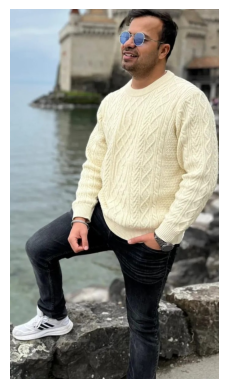

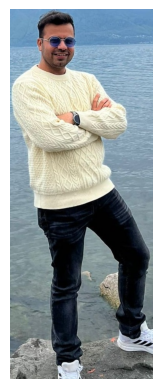

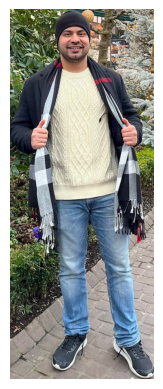

In [67]:
def displayCluster(cluster):
    print(json.dumps(cluster[0], indent=2))
    for item in cluster:
        url = item['url']
        img = Image.open(f'./data/sample/{url.split("/")[-1]}')
        plt.imshow(img)
        plt.axis('off')
        plt.show()

displayCluster(clusters[0])

In [74]:
def dumpClusterInfo(clusters):
    data = []
    for i in range(len(clusters)):
        cluster = clusters[i]
        data.append({
            "name": cluster[0]["name"],
            "features": cluster[0]["features"],
            "color": cluster[0]["color"],
            "items": [item["url"] for item in cluster]
        })
    
    data.sort(key=lambda x: x["name"])

    with open('./web/src/data/clusters.json', 'w') as f:
        json.dump(data, f)

dumpClusterInfo(clusters)